In [1]:
import datetime
import glob

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

import conv_mod

In [2]:
im_size = 128
latent_size = 512
batch_size = 16
cha = 32 #Should be 32
n_layers = int(np.log2(im_size) - 1) -1# 5 for 128 
mixed_prob = 0.9
channels_mult_list = [1,2,4,6,8,16,32,32,64,64]

In [3]:
def latent_z(n):
    # Z 
    return np.random.normal(size=[n, latent_size]).astype('float32')

def noise_image(batch_size):
    return np.random.uniform(size = [batch_size, im_size, im_size, 1]).astype('float32')

#Loss functions
def gradient_penalty(samples, output, weight):
    gradients = K.gradients(output, samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * weight

def crop_to_fit(x):
    height = x[1].shape[1]
    width = x[1].shape[2]
    return x[0][:, :height, :width, :]

def upsample_to_size(x):
    y = im_size // x.shape[2]
    x = K.resize_images(x, y, y, "channels_last",interpolation='bilinear')
    return x

In [4]:
def g_block(x, input_style, input_noise, nb_filters, upsampling = True):
    input_filters = x.shape[-1]
    if upsampling:
        x = keras.layers.UpSampling2D(interpolation='bilinear')(x)
    
    rgb_style = keras.layers.Dense(nb_filters, kernel_initializer = keras.initializers.VarianceScaling(200/x.shape[2]))(input_style)
    style = keras.layers.Dense(input_filters, kernel_initializer = 'he_uniform')(input_style)
    
    noise_cropped = keras.layers.Lambda(crop_to_fit)([input_noise, x]) ########
    d = keras.layers.Dense(nb_filters, kernel_initializer='zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters=nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    style = keras.layers.Dense(nb_filters, kernel_initializer = 'he_uniform')(input_style)
    d = keras.layers.Dense(nb_filters, kernel_initializer = 'zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters = nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    return x, to_rgb(x, rgb_style)

def d_block(inp, fil, p = True):
    res = keras.layers.Conv2D(fil, 1, kernel_initializer = 'he_uniform')(inp)

    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(inp)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(out)
    out = keras.layers.LeakyReLU(0.2)(out)

    out = keras.layers.add([res, out])

    if p:
        out = keras.layers.AveragePooling2D()(out)

    return out

def to_rgb(inp, style):
    size = inp.shape[2]
    x = conv_mod.Conv2DMod(3, 1, kernel_initializer = keras.initializers.VarianceScaling(200/size), 
                              demod = False)([inp, style])
    return keras.layers.Lambda(upsample_to_size, output_shape=[None, im_size, im_size, None])(x)

In [5]:
def cross(vector1, vector2):
    """
    3D cross product between two vectors, potentially batched
    """
    vector1_x, vector1_y, vector1_z = tf.unstack(vector1, axis=-1)
    vector2_x, vector2_y, vector2_z = tf.unstack(vector2, axis=-1)
    n_x = vector1_y * vector2_z - vector1_z * vector2_y
    n_y = vector1_z * vector2_x - vector1_x * vector2_z
    n_z = vector1_x * vector2_y - vector1_y * vector2_x
    return tf.stack((n_x, n_y, n_z), axis=-1)

def trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=8):
    """
    Output the positions to be sampled, as a 3d map
    works on batches 
    
    camera_position: 3-d vector
    camera_direction: 3-d unite vector
    camera_rotaion: float, radian, zero is default
    side: float, radian, what angle the camera is able to view
    """    
    #Finding camera orientation before rotation
    y_dir = tf.constant([0,1,0], dtype=tf.float32) #(*,3)
    camera_x = cross(y_dir, camera_direction) #(*,3)
    camera_y = cross(camera_direction, camera_x) #(*,3)
    
    #Applying camera rotation
    rot_cos = tf.cos(camera_rotation[:,tf.newaxis]) # (*,)
    rot_sin = tf.sin(camera_rotation[:,tf.newaxis]) # (*,)
    camera_x, camera_y = (rot_cos*camera_x + rot_sin*camera_y, 
                          -rot_sin*camera_x + rot_cos*camera_y) # (*,3)
        
    dist_to_zero = tf.norm(camera_position, axis=-1) #(*,)
    half_side = side*dist_to_zero/2 # (*,)
    linspace = tf.linspace(-half_side,half_side, side_count, axis=1) #(*,side_count)
    #Relative to the center of the grid
    grid_x = camera_x[:,tf.newaxis,tf.newaxis,:] * linspace[:,tf.newaxis,:,tf.newaxis] #(*,1,side_count,3)
    grid_y = - camera_y[:,tf.newaxis,tf.newaxis,:] * linspace[:,:,tf.newaxis,tf.newaxis] #(*,side_count,1,3)
    
    grid_xy = grid_x + grid_y # (*,side_count,side_count,3)
    #Relative to camera 
    grid_xy = grid_xy + (dist_to_zero[:,tf.newaxis]*camera_direction)[:,tf.newaxis,tf.newaxis,:]
    
    grid_xyz = grid_xy[:,tf.newaxis,:,:,:] * (1 + linspace/dist_to_zero[:,np.newaxis])[:,:,tf.newaxis,tf.newaxis,tf.newaxis] # (*,side_count,side_count,side_count,3)    
    return grid_xyz + camera_position[:,tf.newaxis,tf.newaxis,tf.newaxis,:]


def to_feature_map(feature_3D):
    """
    Sums the rays along axis 1, output a feature map 
    """
    coefficients = tf.reduce_sum(tf.abs(feature_3D),axis=4, keepdims=True) #(*,side_count,side_count,side_count,1)
    coefficients = 1/(1 + tf.math.cumsum(coefficients, axis=1)) #(*,side_count,side_count,side_count,1)
    feature_map = tf.reduce_sum(coefficients*feature_3D, axis=1) #(*,side_count,side_count,1)
    return feature_map
    
class CameraStd(keras.layers.Layer):
    def __init__(self):
        super(CameraStd, self).__init__()
        """
        Learnable parameters for the standard deviations of the random gaussians noise
        """
        self.theta_std = self.add_weight(name="theta_std", initializer=tf.constant_initializer(0.2))
        self.phi_std = self.add_weight(name="phi_std", initializer=tf.constant_initializer(1.))
        self.rotation_std = self.add_weight(name="rotation_std", initializer=tf.constant_initializer(0.1))
        self.center_std = self.add_weight(name="center_std", initializer=tf.constant_initializer(0.1))
        self.side_std = self.add_weight(name="side_std", initializer=tf.constant_initializer(0.1))
        self.distance_std = self.add_weight(name="distance_std", initializer=tf.constant_initializer(4))
        self.base_distance = self.add_weight(name="base_distance", initializer=tf.constant_initializer(15))
    
        self.dir_x = tf.constant([1,0,0], dtype=tf.float32)
        self.dir_y = tf.constant([0,1,0], dtype=tf.float32)
        self.dir_z = tf.constant([0,0,1], dtype=tf.float32)
    
    def call(self, inputs):
        """
        Inputs, all random values zero centered std 1:
        camera_angles : (*,3)
        center : (*,3)
        distance : (*)
        side : (*)
        """
        camera_angles, center, distance, side = inputs
        
        #Rotation
        theta = camera_angles[:,0] * self.theta_std # (*,)
        phi = camera_angles[:,1] * self.phi_std # (*,)
        camera_rotation = camera_angles[:,2] * self.rotation_std # (*,)
        #print(f"theta: {theta.numpy()}")
        #print(f"phi: {phi.numpy()}")
        #print(f"camera_rotation: {camera_rotation.numpy()}")
        
        #Camera position
        distance = self.base_distance+self.distance_std*distance
        #print(f"distance: {distance.numpy()}")
        dir_camera_phi = tf.cos(phi[:,tf.newaxis]) * self.dir_z + tf.sin(phi[:,tf.newaxis]) * self.dir_x 
        dir_camera = tf.cos(theta[:,tf.newaxis]) * dir_camera_phi + tf.sin(theta[:,tf.newaxis]) * self.dir_y # (*, 3)
        camera_position = dir_camera * distance[:,tf.newaxis] # (*, 3)
            
        #Camera direction
        center = center * self.center_std # (*, 3)
        camera_direction, _ = tf.linalg.normalize(center - camera_position, axis=1)  # (*, 3)
        
        #Side
        side = (self.side_std*side + 1) / distance # (*,)
            
        return camera_position, camera_direction, camera_rotation, side
    
class RayTracer(keras.layers.Layer):
    def __init__(self, side_count=8):
        """
        Sample coordinate accross rays.
        output is of shape (*,side_count,side_count,side_count,3)
        """
        super(RayTracer, self).__init__()
        
        self.side_count = side_count

    def call(self, inputs):
        camera_position, camera_direction, camera_rotation, side = inputs 
        return trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=self.side_count)
    
def get_random_noise(batch_size=8):
    random_noise = tf.random.normal(shape=(batch_size, 8))
    return random_noise[:,:3], random_noise[:,3:6], random_noise[:,6], random_noise[:,7]
   

In [6]:
class StyleGan(keras.Model):
    def __init__(self, steps = 0, lr = 0.0001, log_steps=None):
        super(StyleGan, self).__init__()
        
        #Models
        self.D = self.make_discriminator()
        self.S = self.make_style_map()
        self.G = self.make_generator()
        self.SN = self.make_seed_network()
        
        #Config
        self.LR = lr
        self.steps = steps
        self.beta = 0.999

        self.G_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        self.D_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        
        self.pl_mean = tf.Variable(0, dtype=tf.float32)
        
        logdir = "logs/train_data/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_steps = log_steps
        if log_steps is not None:
            self.file_writer = tf.summary.create_file_writer(logdir)
    
    def make_seed_network(self):
        """
        start_dim = im_size // (2**(n_layers-1))
        style_input = inp_style = keras.layers.Input([n_layers, 512])
        x = tf.stop_gradient(style_input)[:,0,:1] * 0 + 1
        x = keras.layers.Dense(start_dim*start_dim*4*cha, activation = 'relu', 
                             kernel_initializer = 'random_normal')(x)
        x = keras.layers.Reshape([start_dim, start_dim, 4*cha])(x)
        return keras.models.Model(inputs = style_input, outputs = x)
        """

        start_dim = im_size // (2**(n_layers-1))
        style_input = keras.layers.Input([n_layers, 512])
        
        #x = tf.stop_gradient(style_input)[:,0,:1] * 0 + 1
        #x = keras.layers.Dense(start_dim*start_dim*128, activation = 'relu', 
                 #            kernel_initializer = 'random_normal')(x)
        #x = tf.stop_gradient(0*keras.layers.Reshape([start_dim, start_dim, 128])(x))
        
        
        r = get_random_noise(batch_size=tf.shape(style_input)[0])
        random_view = CameraStd()(r)
        rays = RayTracer()(random_view)

        hiddens = keras.layers.Dense(128,activation="relu")(rays)
        hiddens = keras.layers.Dense(128,activation="relu")(hiddens)
        hiddens = keras.layers.Dense(128,activation="relu")(hiddens)
        
        feature_map = to_feature_map(hiddens) #+ x
        
        return keras.models.Model(inputs = style_input, outputs = feature_map)
    
    def make_discriminator(self):
        d_input = keras.layers.Input(shape = [im_size, im_size, 3])
        x = d_input
        
        nb_d_layers = int(np.log2(im_size))
        channels_mult = 1
        nb_D_layer = int(np.log2(im_size)) - 1 
        for channels_mult in channels_mult_list[:nb_D_layer-1]:
            x = d_block(x, channels_mult * cha)
        x = d_block(x, channels_mult_list[nb_D_layer-1] * cha, p = False)
        
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1, kernel_initializer = 'he_uniform')(x)
        return keras.models.Model(inputs = d_input, outputs = x)

    def make_style_map(self):
        S = keras.models.Sequential()
        S.add(keras.layers.Dense(512, input_shape = [latent_size]))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        return S
    
    def make_generator(self):
        start_dim = im_size // (2**(n_layers-1))
        
        inp_seed = keras.layers.Input([start_dim, start_dim, 4*cha])
        inp_style = keras.layers.Input([n_layers, 512])
        inp_noise = keras.layers.Input([im_size, im_size, 1])
    
        #Latent
        #x = inp_style[:,0,:1] * 0 + 1

        outs = []
        x = inp_seed

        #x = keras.layers.Dense(start_dim*start_dim*start_dim*cha, activation = 'relu', 
        #                      kernel_initializer = 'random_normal')(x)
        #x = keras.layers.Reshape([start_dim, start_dim, 4*cha])(x)
    
        
        for i, channels_mult in enumerate(channels_mult_list[:n_layers][::-1]):
            x, r = g_block(x, inp_style[:,i], inp_noise, channels_mult * cha, upsampling = (i!=0))  
            outs.append(r)
        x = keras.layers.add(outs)
        x = keras.layers.Lambda(lambda y: y/2 + 0.5)(x) #Use values centered around 0, but normalize to [0, 1], providing better initialization
        return keras.models.Model(inputs = [inp_seed, inp_style, inp_noise], outputs = x)

    @tf.function
    def tf_train_step(self, images, style1, style2, style2_idx, noise, perform_gp=True, perform_pl=False):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Get style information
            w_1 = self.S(style1)
            w_2 = self.S(style2)
            w_space = tf.repeat(tf.stack([w_1,w_2], axis=1),[style2_idx, n_layers-style2_idx],axis=1)
            pl_lengths = self.pl_mean

            #Generate images
            seed = self.SN(w_space)
            generated_images = self.G([seed, w_space, noise])

            #Discriminate
            real_output = self.D(images, training=True)
            fake_output = self.D(generated_images, training=True)

            #Hinge loss function
            gen_loss = K.mean(fake_output)
            divergence = K.mean(K.relu(1 + real_output) + K.relu(1 - fake_output))
            disc_loss = divergence

            if perform_gp:
                #R1 gradient penalty
                disc_loss += gradient_penalty(images, real_output, 10)

            if perform_pl:
                #Slightly adjust W space
                w_space_2 = []
                for i in range(n_layers):
                    w_slice = w_space[:,i]
                    std = 0.1 / (K.std(w_slice, axis = 0, keepdims = True) + 1e-8)
                    w_space_2.append(w_slice + K.random_normal(tf.shape(w_slice)) / (std + 1e-8))
                w_space_2 = tf.stack(w_space_2, axis=1)
                #Generate from slightly adjusted W space
                pl_images = self.G([seed, w_space_2,noise], training=True)

                #Get distance after adjustment (path length)
                pl_lengths = K.mean(K.square(pl_images - generated_images), axis = [1, 2, 3])
                if self.pl_mean > 0 :
                    gen_loss += K.mean(K.square(pl_lengths - self.pl_mean))

        #Get gradients for respective areas
        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables + self.S.trainable_variables + self.SN.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        #Apply gradients
        self.G_opt.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables + self.S.trainable_variables + self.SN.trainable_variables))
        self.D_opt.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

        return disc_loss, gen_loss, divergence, pl_lengths
    
    def train_step(self, args):
        images, style1, style2, style2_idx, noise = args
        self.steps += 1
        
        apply_gradient_penalty = self.steps % 2 == 0 or self.steps < 10000
        apply_path_penalty = self.steps % 16 == 0
        
        disc_loss, gen_loss, divergence, pl_lengths = self.tf_train_step(images, style1, style2, 
                                                                         style2_idx, noise, 
                                                                         apply_gradient_penalty, 
                                                                         apply_path_penalty)
        
        if self.pl_mean == 0:
            self.pl_mean.assign(tf.reduce_mean(pl_lengths))
        self.pl_mean.assign(0.99*self.pl_mean + 0.01*tf.reduce_mean(pl_lengths))
        
        if self.log_steps and not self.steps % self.log_steps:
            with self.file_writer.as_default():
                noise = noise_image(9)
                l_z = latent_z(9)
                l_w = self.S(l_z)
                style = tf.stack([l_w for i in range(n_layers)],axis=1)
                seed = self.SN(style)
                generated = self.G([seed, style,noise])
                img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) for i in range(3)], axis=0)
                tf.summary.image("Training data", [img], step=self.steps)
        
        return {
            "disc_loss":disc_loss,
            "gen_loss":gen_loss,
            "divergence":divergence,
            "pl_lengths":pl_lengths,
        }
            

In [7]:
def read_image(im_path):
    im_file = tf.io.read_file(im_path)
    im = tf.io.decode_jpeg(im_file, channels=3)
    im = tf.image.resize(im, (im_size,im_size))
    im = tf.image.convert_image_dtype(im, tf.float32)/255
    im = tf.image.random_flip_left_right(im)
    return im

def train_dataset():
    path = "/Data/leo/dogs-face-2015/*.jpg"
    im_dataset = tf.data.Dataset.list_files(path)
    im_dataset = im_dataset.map(read_image)
    im_dataset = im_dataset.repeat()
    im_dataset = im_dataset.batch(batch_size)
    
    nb_train_image = len(glob.glob(path))
    print("Number of train images found:", nb_train_image)
    
    def gen_latent_z():
        while 1:
            yield latent_z(batch_size)
 
    def gen_noise():
        while 1:
            yield noise_image(batch_size)
            
    def gen_mixed_idx():
        while 1:
            if np.random.random() < mixed_prob:
                yield np.random.randint(n_layers)
            else:
                yield n_layers
                       
    latent_z1_dataset = tf.data.Dataset.from_generator(gen_latent_z, tf.float32, output_shapes=(batch_size, latent_size))
    latent_z2_dataset = tf.data.Dataset.from_generator(gen_latent_z, tf.float32, output_shapes=(batch_size, latent_size))
    noise_dataset = tf.data.Dataset.from_generator(gen_noise, (tf.float32))
    mixed_idx_dataset = tf.data.Dataset.from_generator(gen_mixed_idx, (tf.int32))
    
    dataset = tf.data.Dataset.zip((im_dataset, latent_z1_dataset, latent_z2_dataset, 
                                   mixed_idx_dataset, noise_dataset))
    dataset = dataset.prefetch(1)
    return dataset

In [40]:
model = StyleGan(log_steps=1000)
model.compile(run_eagerly=True)

Eagerly False: 328 ms

In [133]:
print(f"{1:03}")

001


In [ ]:
for i in range(200):
    print("Epoch", i)
    dataset = train_dataset().take(52597//batch_size)
    model.fit(dataset)
    model.save_weights(f"models/3d-model-good-{i:03}.tf")

Epoch 0
Number of train images found: 52597
   1721/Unknown - 705s 409ms/step - disc_loss: 1.9092 - gen_loss: 0.1624 - divergence: 1.8111 - pl_lengths: 0.2050

Ran 42 epoch

In [10]:
#model.save_weights("models/3d-model-good.tf")

In [41]:
model.load_weights("models/3d-model-good.tf")

In [123]:
tf.concat([tf.linspace(-3.,3, 9)[:,tf.newaxis], tf.zeros((9,2), dtype=tf.float32)], axis=1)

<tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[-3.  ,  0.  ,  0.  ],
       [-2.25,  0.  ,  0.  ],
       [-1.5 ,  0.  ,  0.  ],
       [-0.75,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.75,  0.  ,  0.  ],
       [ 1.5 ,  0.  ,  0.  ],
       [ 2.25,  0.  ,  0.  ],
       [ 3.  ,  0.  ,  0.  ]], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


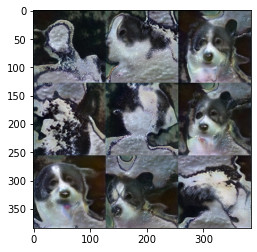

In [129]:
import matplotlib.pyplot as plt

random_noise = tf.zeros(shape=(9, 8))
arg1 =  tf.concat([tf.linspace(-3.,3, 9)[:,tf.newaxis], tf.zeros((9,2), dtype=tf.float32)], axis=1)
args = random_noise[:,:3], arg1, random_noise[:,6], random_noise[:,7]

noise = noise_image(9)
l_z = latent_z(1)
l_w = model.S(l_z)
style = tf.stack([l_w for i in range(n_layers)],axis=1)
style = style * tf.ones([9,1,1])

seed = controlled_SN(args)

generated = model.G([seed, style, noise])
img = tf.concat([tf.
                 concat([generated[3*i+k] for k in range(3)], axis=1) for i in range(3)], axis=0)
plt.imshow(img)

In [63]:
def make_controlled_seed_network(seed_network=None):
    style_input = keras.layers.Input([n_layers, 512])
    r = get_random_noise(batch_size=tf.shape(style_input)[0])
    random_view = CameraStd()(r)
    rays = RayTracer()(random_view)
    hiddens = keras.layers.Dense(128,activation="relu")(rays)
    hiddens = keras.layers.Dense(128,activation="relu")(hiddens)
    hiddens = keras.layers.Dense(128,activation="relu")(hiddens)
    feature_map = to_feature_map(hiddens) 
    controlled_SN = keras.models.Model(inputs = style_input, outputs = feature_map)
    
    random_noise = tf.random.normal(shape=(batch_size, 8))
    args = random_noise[:,:3], random_noise[:,3:6], random_noise[:,6], random_noise[:,7]
    _ = controlled_SN(args)
    
    if seed_network is not None:
        for w_to_copy, w_receiver in zip(seed_network.weights, controlled_SN.weights):
            w_receiver.assign(w_to_copy)
    return controlled_SN

controlled_SN = make_controlled_seed_network(model.SN)